In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras import layers, models, applications, regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report

# Checar se tem GPU disponível

In [2]:
print("Num GPUs Disp:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Disp: 1


In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Ativa a primeira GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        device = '/GPU:0'
        print("✅ Usando GPU")
    except RuntimeError as e:
        print("⚠️ Erro ao configurar GPU:", e)
        device = '/CPU:0'
else:
    print("❌ GPU não disponível, usando CPU")
    device = '/CPU:0'

✅ Usando GPU


# Criando a estrutura do projeto

In [4]:
IA_path = os.path.join('data','IA') #caminho das imagens geradas por IA
Real_path = os.path.join('data','Real') #caminho das imagens de pessoas reais

#criando pastas
os.makedirs(IA_path, exist_ok=True)
os.makedirs(Real_path, exist_ok=True)

# Pré-Processamento das Imagens e Divisão Train/Test/Val

In [10]:
# --- Constants ---
IMG_SIZE = (100, 100)
BATCH_SIZE = 1028
total_samples = 163_233
AUTOTUNE = tf.data.AUTOTUNE

# --- Preprocessing images (central crop + resize) ---
def preprocess(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    # image = tf.image.resize_with_crop_or_pad(image, 160, 160)
    # image = tf.image.central_crop(image, central_fraction=0.8)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# --- Data Augmentation (only for training) ---
def augment(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.2)
    x = tf.image.random_contrast(x, 0.8, 1.2)
    return x, y

# --- Load filepaths separately ---
ia_files = tf.data.Dataset.list_files(IA_path + '/*.jpg', shuffle=True)
real_files = tf.data.Dataset.list_files(Real_path + '/*.jpg', shuffle=True)

# --- Map to (image, label) ---
ia_ds = ia_files.map(lambda x: (preprocess(x), tf.constant(1)), num_parallel_calls=AUTOTUNE)
real_ds = real_files.map(lambda x: (preprocess(x), tf.constant(0)), num_parallel_calls=AUTOTUNE)

# --- Balance classes using sample_from_datasets ---
balanced_ds = tf.data.Dataset.sample_from_datasets([real_ds, ia_ds], weights=[0.5, 0.5])
balanced_ds = balanced_ds.shuffle(500, seed=42)

# --- Split manually ---
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

train_ds = balanced_ds.take(train_size).map(augment, num_parallel_calls=AUTOTUNE)
val_test_ds = balanced_ds.skip(train_size)

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# --- Batch and prefetch ---
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Exemplos do Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.032509685..0.87842745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005864829..1.0256755].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14315343..1.2243521].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12712577..1.0652566].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1957505..0.9432087].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13871771..0.74476117].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.

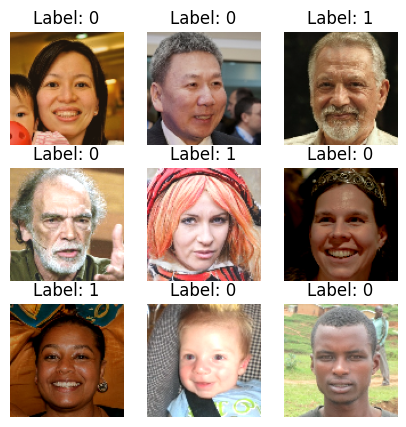

In [11]:
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy() # -> 1 - IA, 0 - Real
    
    plt.figure(figsize=(5, 5))
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i]) 
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

# Construção do Modelo Pré-treinado 1 - MobileNetV2

In [12]:
# --- Model (InceptionResNetV2 base) ---
base_model = applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3),
    classifier_activation="softmax",
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               196736    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 54,533,601
Trainable params: 196,865
Non

In [13]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)

In [14]:
# --- Train ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping_cb, reduce_lr_cb]
)

Epoch 1/20
112/112 [==============================] - 165s 1s/step - loss: 0.6984 - accuracy: 0.6312 - val_loss: 0.6079 - val_accuracy: 0.6902 - lr: 1.0000e-04
Epoch 2/20
112/112 [==============================] - 151s 1s/step - loss: 0.6111 - accuracy: 0.6844 - val_loss: 0.5799 - val_accuracy: 0.7087 - lr: 1.0000e-04
Epoch 3/20
112/112 [==============================] - 151s 1s/step - loss: 0.5880 - accuracy: 0.7023 - val_loss: 0.5636 - val_accuracy: 0.7221 - lr: 1.0000e-04
Epoch 4/20
112/112 [==============================] - 153s 1s/step - loss: 0.5750 - accuracy: 0.7128 - val_loss: 0.5618 - val_accuracy: 0.7192 - lr: 1.0000e-04
Epoch 5/20
112/112 [==============================] - 150s 1s/step - loss: 0.5646 - accuracy: 0.7202 - val_loss: 0.5470 - val_accuracy: 0.7328 - lr: 1.0000e-04
Epoch 6/20
112/112 [==============================] - 154s 1s/step - loss: 0.5565 - accuracy: 0.7269 - val_loss: 0.5394 - val_accuracy: 0.7386 - lr: 1.0000e-04
Epoch 7/20
112/112 [====================

# Resultados

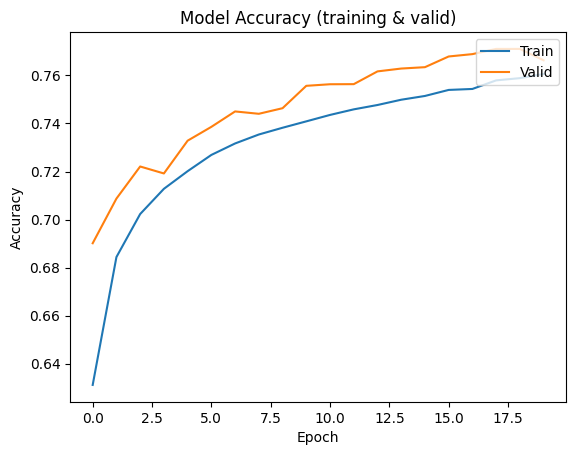

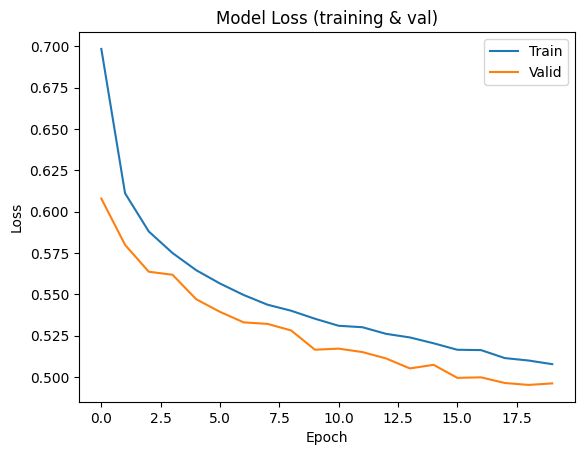

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

# Testando no Conjunto de Teste

In [16]:
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.4f}")

24/24 [==============================] - 100s 575ms/step - loss: 0.4991 - accuracy: 0.7619
Test accuracy: 0.7619


# Métricas

In [17]:
# --- Obter probabilidades e rótulos reais em batches ---
y_probs = []
y_true = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)  # previsões por batch
    y_probs.append(probs)
    y_true.append(labels.numpy())

# Concatena após loop
y_probs = np.concatenate(y_probs).reshape(-1)
y_pred = (y_probs > 0.5).astype(int)
y_true = np.concatenate(y_true).astype(int)

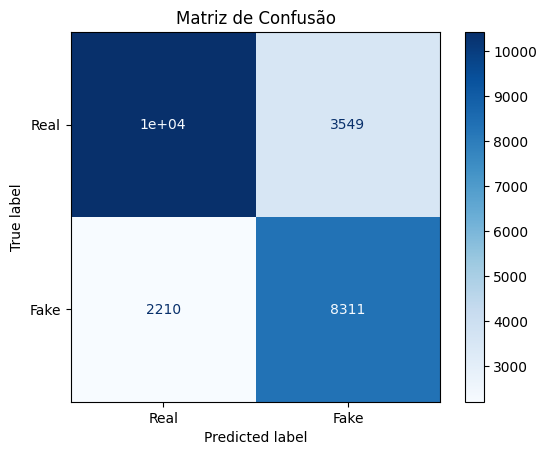

In [18]:
# --- Matriz de Confusão ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão")
plt.show()

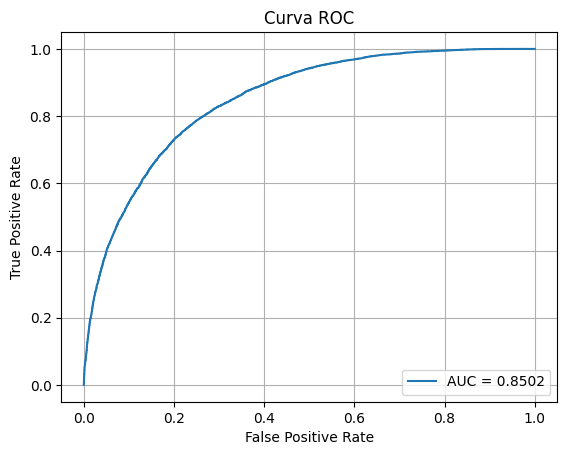

In [19]:
# --- Curva ROC ---
fpr, tpr, _ = roc_curve(y_true, y_probs)  # usar probabilidades para a curva
auc = roc_auc_score(y_true, y_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Curva ROC")
plt.legend(loc=4)
plt.grid(True)
plt.show()

In [20]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

              precision    recall  f1-score   support

        Real       0.82      0.75      0.78     13965
        Fake       0.70      0.79      0.74     10521

    accuracy                           0.76     24486
   macro avg       0.76      0.77      0.76     24486
weighted avg       0.77      0.76      0.77     24486

